<a href="https://colab.research.google.com/github/VeronikaShe/ML-study_HW_3/blob/main/Intro_to_NN_3_hw_shemyakina_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [33]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [34]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

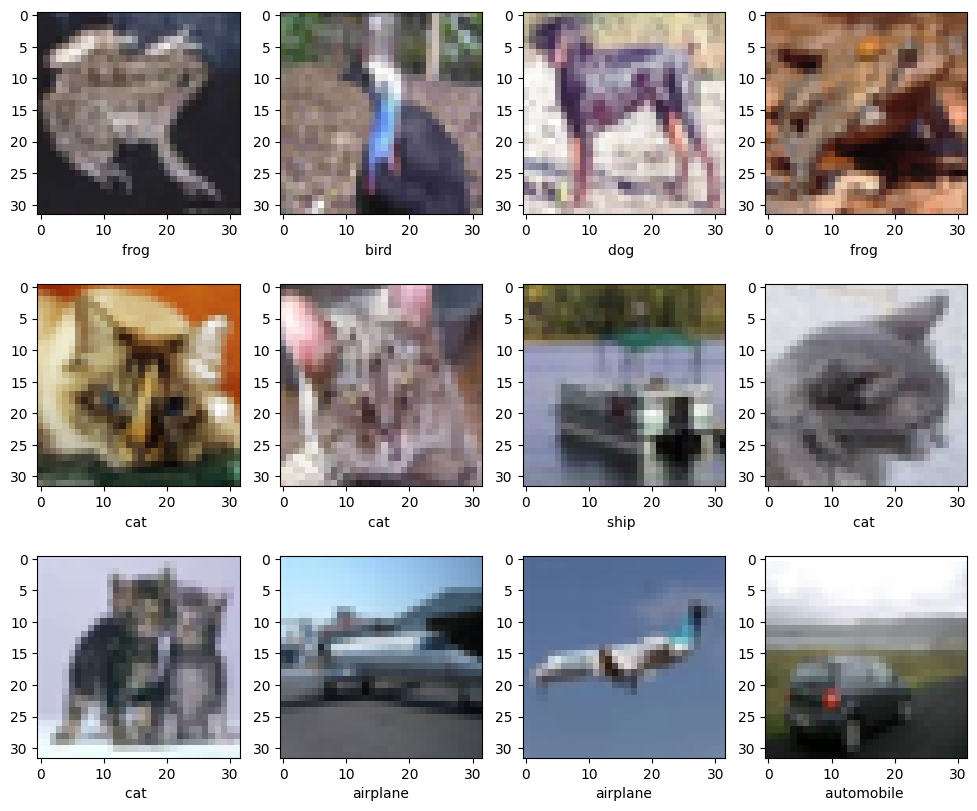

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [36]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [37]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [38]:
import keras
from keras import layers as L
from keras import backend as K
from keras import ops as ops
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [39]:

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')

])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [41]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [42]:
def scheduler(epoch, lr):
   if epoch < 10:
    return float(lr)
   else:
    return float(lr * ops.exp(-0.1))

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                    mode='max', min_delta=0.001,
                    patience = 3),
             keras.callbacks.LearningRateScheduler(scheduler)]

In [43]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [45]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(y_train_labels.shape)

(40000, 32, 32, 3) (40000, 10)
(10000, 32, 32, 3) (10000, 10)
(40000, 10, 2)


In [46]:
model.fit(X_train, y_train, batch_size=16, epochs=512, callbacks=callbacks, verbose=1, validation_split=0.2, validation_data=[X_val, y_val])

Epoch 1/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.2394 - loss: 2.0528 - val_accuracy: 0.3725 - val_loss: 1.7287 - learning_rate: 0.0100
Epoch 2/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3939 - loss: 1.6984 - val_accuracy: 0.4071 - val_loss: 1.6576 - learning_rate: 0.0100
Epoch 3/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4351 - loss: 1.5852 - val_accuracy: 0.4391 - val_loss: 1.5706 - learning_rate: 0.0100
Epoch 4/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4567 - loss: 1.5198 - val_accuracy: 0.4434 - val_loss: 1.5654 - learning_rate: 0.0100
Epoch 5/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4802 - loss: 1.4651 - val_accuracy: 0.4599 - val_loss: 1.5019 - learning_rate: 0.0100
Epoch 6/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4948 - loss: 1.4203 - val_accuracy: 0.4742 - val_loss: 1.4811 - learning_rate: 0.0100
Epoch 7/512
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [47]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Test_acc = 0.5064
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [48]:
## TODO
new_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [51]:
## TODO
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
new_model.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/32
1988/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3394 - loss: 1.8292

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3398 - loss: 1.8280 - val_accuracy: 0.4906 - val_loss: 1.4160
Epoch 2/32
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5173 - loss: 1.3661

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5174 - loss: 1.3660 - val_accuracy: 0.5219 - val_loss: 1.3332
Epoch 3/32
1989/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5657 - loss: 1.2439

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5657 - loss: 1.2440 - val_accuracy: 0.5242 - val_loss: 1.3387
Epoch 4/32
1988/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5869 - loss: 1.1877

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5869 - loss: 1.1877 - val_accuracy: 0.5444 - val_loss: 1.2969
Epoch 5/32
1990/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6114 - loss: 1.1190

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6114 - loss: 1.1190 - val_accuracy: 0.5617 - val_loss: 1.2393
Epoch 6/32
1992/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6235 - loss: 1.0754

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6235 - loss: 1.0754 - val_accuracy: 0.5753 - val_loss: 1.2169
Epoch 7/32
1989/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6378 - loss: 1.0307

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6378 - loss: 1.0307 - val_accuracy: 0.5816 - val_loss: 1.2096
Epoch 8/32
1991/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6511 - loss: 0.9977

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6511 - loss: 0.9977 - val_accuracy: 0.5734 - val_loss: 1.2307
Epoch 9/32
1995/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6683 - loss: 0.9483

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6683 - loss: 0.9484 - val_accuracy: 0.5857 - val_loss: 1.2145
Epoch 10/32
1990/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 0.9007

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6832 - loss: 0.9009 - val_accuracy: 0.5773 - val_loss: 1.2315


Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [52]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Test_acc = 0.5763
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [53]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [54]:
!rm -rf ./logs

In [55]:
## TODO
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizers = 'adam'


In [56]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

/tmp/ipython-input-2505868840.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/1 [00:00<?, ?it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final score of single_model_<class 'str'> is 0.4095


In [57]:
!pwd

/content


Оптимизатор sgd дал точность выше adam.

'adagrad' score = 0.4812

'sgd' score = 0.462

'adam' score = 0.4068

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [58]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

Прокомментируйте полученные результаты.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [60]:
val_datagen = ImageDataGenerator()

split = 30000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

##dg_y_train, dg_y_val = (keras.utils.to_categorical(y) for y in (dg_y_train, dg_y_val))
print (dg_x_train.shape,dg_y_train.shape)
print (dg_x_val.shape,dg_y_val.shape)
print (X_train.shape,y_train.shape)

## (40000, 32, 32, 3) (40000, 10)

(30000, 32, 32, 3) (30000, 10)
(10000, 32, 32, 3) (10000, 10)
(40000, 32, 32, 3) (40000, 10)


In [110]:
## TODO
final_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='leaky_relu',
                           input_shape=dg_x_train.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='leaky_relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Conv2D(filters=128,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='leaky_relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
def scheduler(epoch, lr):
   if epoch < 10:
    return float(lr)
   else:
    return float(lr * ops.exp(-0.1))

final_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                    mode='max', min_delta=0.001,
                    patience = 3),
                   keras.callbacks.LearningRateScheduler(scheduler)]

In [104]:
final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [107]:
## TODO
final_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=64), epochs=1024, callbacks=final_callbacks, validation_data = val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/1024
  1/469 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.8438 - loss: 0.5306

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8181 - loss: 0.5138 - val_accuracy: 0.7680 - val_loss: 0.7491 - learning_rate: 0.0010
Epoch 2/1024
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.8277 - loss: 0.4984 - val_accuracy: 0.7740 - val_loss: 0.7308 - learning_rate: 0.0010
Epoch 3/1024
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8279 - loss: 0.4860 - val_accuracy: 0.7752 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 4/1024
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.8264 - loss: 0.4884 - val_accuracy: 0.7830 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 5/1024
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8408 - loss: 0.4598 - val_accuracy: 0.7781 - val_loss: 0.7371 - learning_rate: 0.0010
Epoch 6/1024
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8387 - loss: 0.4579 - val_accuracy: 0.7893 - val_loss: 0.7016 - learning_rate: 0.0010
Epoch 7/1024
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8383 - 

Момент истины: проверьте, какого качества достигла ваша сеть.

In [108]:
from sklearn.metrics import accuracy_score

predict_x=final_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Test_acc = 0.816
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.
Эксперементов было много. Результат каждого из них что-то непредсказуемое. Мого времени ушло на исправление ошибок нарушения размерности. Для повышения точности модели следующие методы помогли:

- изменение функций активации в слоях

- добавление dence-слоев

- увеличение количества эпох обучения

- изменение методов оптимизации

- увеличение количества фильтров

- изменение функции выбора шага обучения и точки останова

Пример подходов к изменению построения НС в последнем задании:

ШАГ 1. adgad - уменьшил точность

ШАГ 2. sgd - уменьшил точность

ШАГ 3. patience снизила с 5 до 2 - снизилась точность до 0.7224

ШАГ 4. Вернула patience до 3, добавила leaky_relu - точность на ранних эпохах снизилась, на поздних эпохах повысилась до 0.7905

ШАГ 5. Заменила leaky_relu на gelu - точность снизилась до 0.7554

ШАГ 6. Заменила gelu на relu - точность снизилась до 0.7586

ШАГ 7. Заменила 2ой и 3ий dence с relu на leaky_relu - точность повысилась до 0.7911

ШАГ 8. Заменила 1ый dence с relu на leaky_relu и увеличила batch_size с 32 до 64 - точность повысилась до 0.7915

ШАГ 9. Добавила 4ый dence с leaky_relu - точность повысилась до 0.816